In [1]:
import os
import random

from einops import rearrange
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from skimage.feature import hog
from tqdm import tqdm

### Presenting data

In [32]:
def read_images(path, size=64):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        label_mode='categorical',
        shuffle=True,
        seed=42,
        image_size=(size, size),
    )
    
    images, _ = zip(*ds)
    images = np.concatenate(images)
    return images

In [33]:
train_images = read_images('data/train/')
test_images = read_images('data/test/')
labels = sorted(os.listdir('data/train'))

Found 10019 files belonging to 10 classes.
Found 500 files belonging to 10 classes.


In [34]:
print(labels)

['fish', 'five', 'four', 'mega', 'mirror', 'pyra', 'square', 'squeb', 'three', 'two']


In [35]:
def show_random_images(images, cmap=None):
    choosen = random.choices(images, k=25)
    choosen = rearrange(choosen, '(nh nw) h w c -> (nh h) (nw w) c', nw=5).astype(int)
    plt.imshow(choosen, cmap)

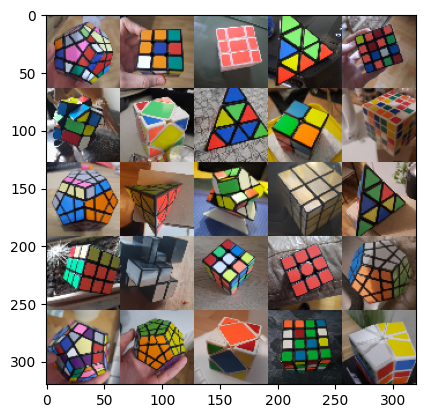

In [36]:
show_random_images(train_images)

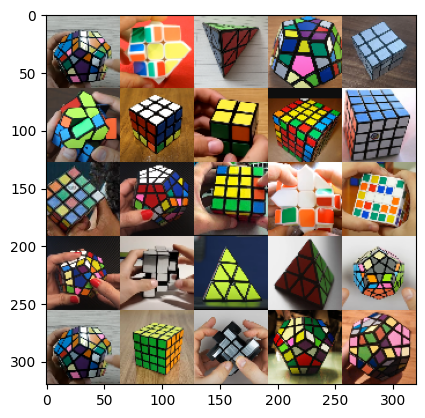

In [37]:
show_random_images(test_images)

# HOG

In [6]:
def apply_hog(rgb_image):
    gray_image = cv.cvtColor(rgb_image, cv.COLOR_RGB2GRAY) / 256
    result = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(1, 1), channel_axis=None, feature_vector=False)
    return np.squeeze(result)

In [9]:
def read_hog_images(path, size):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        label_mode='categorical',
        shuffle=True,
        seed=42,
        image_size=(size, size),
        batch_size=1
    )
    
    X = []
    y = []
    
    for rgb_image, label in tqdm(ds, total=len(ds)):
        hog_image = apply_hog(rgb_image[0].numpy())
        X.append(hog_image)
        y.append(label[0].numpy())
        
    X = np.array(X)
    y = np.array(y)
    return X, y

In [10]:
train_X, train_y = read_hog_images('data/train/', size=512)
test_X, test_y = read_hog_images('data/test/', size=512)

Found 10019 files belonging to 10 classes.


100%|██████████| 10019/10019 [18:08<00:00,  9.20it/s]


Found 500 files belonging to 10 classes.


100%|██████████| 500/500 [00:53<00:00,  9.41it/s]


In [41]:
# for faster rerunning
np.save('saved_models/train_X', train_X)
np.save('saved_models/test_X', test_X)
np.save('saved_models/train_y', train_y)
np.save('saved_models/test_y', test_y)

In [4]:
train_X = np.load('saved_models/train_X.npy')
test_X = np.load('saved_models/test_X.npy')
train_y = np.load('saved_models/train_y.npy')
test_y = np.load('saved_models/test_y.npy')

### Creating CNN

In [5]:
model = Sequential([
    layers.Input(shape=(64, 64, 9)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax'),
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        2624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [7]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [8]:
callbacks   = [
      EarlyStopping(monitor='val_categorical_accuracy', patience=10, mode='max', restore_best_weights=True),
]

history = model.fit(
    train_X,
    train_y,
    validation_data=(test_X, test_y),
    epochs=500,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/500
314/314 [==============================] - 7s 10ms/step - loss: 2.0049 - categorical_accuracy: 0.2239 - val_loss: 1.8896 - val_categorical_accuracy: 0.3140
Epoch 2/500
314/314 [==============================] - 3s 9ms/step - loss: 0.9430 - categorical_accuracy: 0.6452 - val_loss: 2.1499 - val_categorical_accuracy: 0.4220
Epoch 3/500
314/314 [==============================] - 3s 9ms/step - loss: 0.5198 - categorical_accuracy: 0.8102 - val_loss: 1.6377 - val_categorical_accuracy: 0.5280
Epoch 4/500
314/314 [==============================] - 3s 9ms/step - loss: 0.3442 - categorical_accuracy: 0.8772 - val_loss: 1.6153 - val_categorical_accuracy: 0.5400
Epoch 5/500
314/314 [==============================] - 3s 9ms/step - loss: 0.2598 - categorical_accuracy: 0.9089 - val_loss: 1.8435 - val_categorical_accuracy: 0.6060
Epoch 6/500
314/314 [==============================] - 3s 9ms/step - loss: 0.1976 - categorical_accuracy: 0.9335 - val_loss: 1.5019 - val_categorical_accuracy: 0.64

### Results

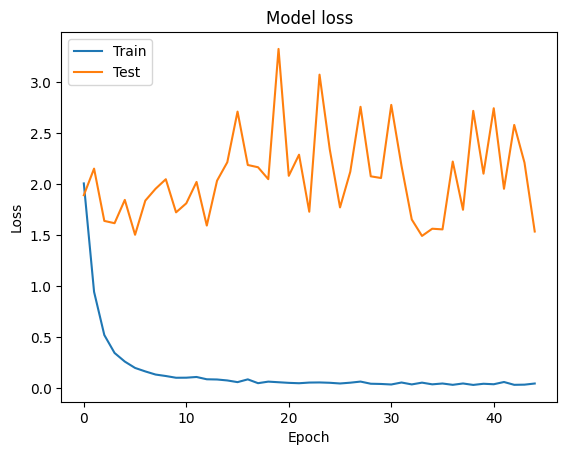

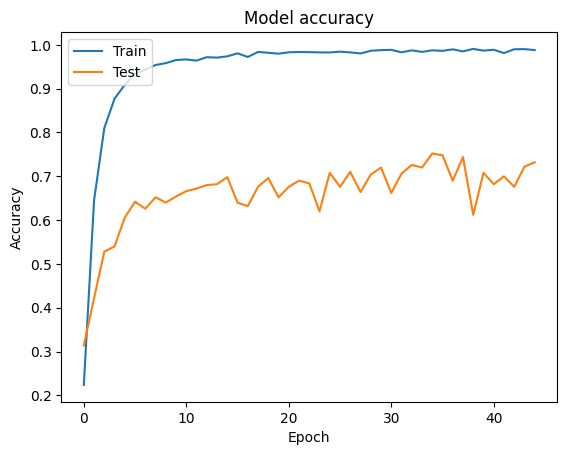

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

16/16 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0       0.73      0.74      0.73        50
           1       0.69      0.68      0.69        50
           2       0.57      0.58      0.57        50
           3       0.96      0.88      0.92        50
           4       0.56      0.80      0.66        50
           5       0.73      0.98      0.84        50
           6       0.87      0.92      0.89        50
           7       1.00      0.82      0.90        50
           8       0.70      0.66      0.68        50
           9       0.96      0.46      0.62        50

    accuracy                           0.75       500
   macro avg       0.78      0.75      0.75       500
weighted avg       0.78      0.75      0.75       500



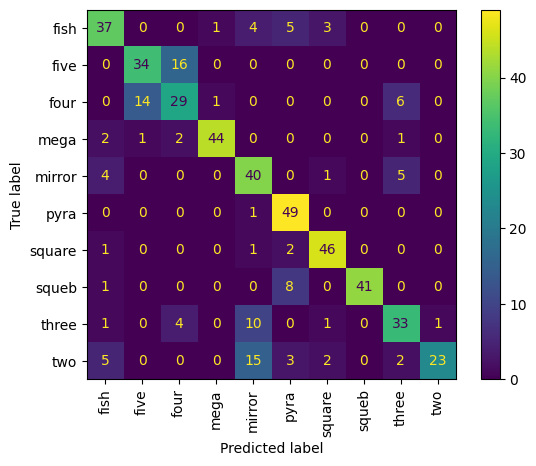

In [11]:
predictions = model.predict(test_X)
true_classes = np.argmax(test_y, axis=1)
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    display_labels=labels, 
    xticks_rotation='vertical',
);